# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/alexanderdahm/Documents/GitHub/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 15, 52, 24, 212554)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-16 15:52:24,215 INFO: Initializing external client
2025-11-16 15:52:24,216 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:52:25,023 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:52:25,954 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286299


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

#
retrieved_model_roll3 = mr.get_model(
    name="air_quality_xgboost_model_roll3",
    version=1,
)

fv_roll3 = retrieved_model_roll3.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir_roll3 = retrieved_model_roll3.download()

2025-11-16 15:52:28,576 INFO: There is no parent information


Downloading: 0.000%|          | 0/437699 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/129322 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19541 elapsed<00:00 remaining<?

2025-11-16 15:52:34,958 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/450156 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/437699 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/128299 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/21270 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

# Roll3 model
retrieved_xgboost_model_roll3 = XGBRegressor()

retrieved_xgboost_model_roll3.load_model(saved_model_dir_roll3 + "/model_pm25_roll3.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_roll3

XGBRegressor(base_score='1.8490301E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data['date'] = pd.to_datetime(batch_data['date'], utc=True).dt.tz_convert(None) #New
batch_data = batch_data.sort_values('date').reset_index(drop=True) #New
batch_data

# Roll3: Get histroic air quality data
air_quality_hist = air_quality_fg.read()[['date', 'pm25']]

air_quality_hist['date'] = pd.to_datetime(air_quality_hist['date'], utc=True).dt.tz_convert(None)
air_quality_hist = air_quality_hist.sort_values('date').set_index('date')
air_quality_hist

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 


,pm25
date,
2022-09-05,17.0
2022-09-06,13.0
2022-09-07,14.0
2022-09-08,10.0
2022-09-09,10.0
...,...
2025-11-11,4.0
2025-11-12,2.0
2025-11-13,28.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
# Old model predictions
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

# Roll3 model predictions, iteratively calculating lagging mean of aq from last 3 days
preds_new = []
pm25_roll3_vals = []

for i, row in batch_data.iterrows():
    # Get previous 3 days of air quality value
    last3 = air_quality_hist['pm25'].tail(3)
    if len(last3) < 3:
        pm25_roll3 = float('nan')
    else:
        pm25_roll3 = last3.mean()
    pm25_roll3_vals.append(pm25_roll3)

    # Predict new air quality value and add it so it can be used to calcualte the next roll3 mean
    X_row = pd.DataFrame([{'pm25_roll3': pm25_roll3, 'temperature_2m_mean': float(row['temperature_2m_mean']), 'precipitation_sum': float(row['precipitation_sum']), 'wind_speed_10m_max': float(row['wind_speed_10m_max']), 'wind_direction_10m_dominant': float(row['wind_direction_10m_dominant']),}])

    y_hat = float(retrieved_xgboost_model_roll3.predict(X_row)[0])
    preds_new.append(y_hat)

    # Save predicted air quality in air_quality_hist
    air_quality_hist.loc[row['date']] = y_hat

batch_data['pm25_roll3'] = pm25_roll3_vals
batch_data['predicted_pm25_new'] = preds_new

batch_data.head()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         5 non-null      datetime64[us]
 1   temperature_2m_mean          5 non-null      float32       
 2   precipitation_sum            5 non-null      float32       
 3   wind_speed_10m_max           5 non-null      float32       
 4   wind_direction_10m_dominant  5 non-null      float32       
 5   city                         5 non-null      object        
 6   predicted_pm25               5 non-null      float32       
 7   pm25_roll3                   5 non-null      float64       
 8   predicted_pm25_new           5 non-null      float64       
dtypes: datetime64[us](1), float32(5), float64(2), object(1)
memory usage: 388.0+ bytes


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_roll3,predicted_pm25_new
0,2025-11-17,-3.65,0.0,9.826088,298.442810,ostersund,51.230469,12.000000,17.982212
1,2025-11-18,-2.35,0.0,8.049845,333.435028,ostersund,59.931034,8.660737,12.727987
2,2025-11-19,-2.95,0.0,2.099143,239.036301,ostersund,23.392899,10.903400,16.623226
3,2025-11-20,-6.40,0.0,3.054701,224.999893,ostersund,30.715239,15.777809,38.213985
4,2025-11-21,-6.00,0.0,0.509117,135.000107,ostersund,57.735363,22.521733,42.846497


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         5 non-null      datetime64[us]
 1   temperature_2m_mean          5 non-null      float32       
 2   precipitation_sum            5 non-null      float32       
 3   wind_speed_10m_max           5 non-null      float32       
 4   wind_direction_10m_dominant  5 non-null      float32       
 5   city                         5 non-null      object        
 6   predicted_pm25               5 non-null      float32       
 7   pm25_roll3                   5 non-null      float64       
 8   predicted_pm25_new           5 non-null      float64       
dtypes: datetime64[us](1), float32(5), float64(2), object(1)
memory usage: 388.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_roll3,predicted_pm25_new,street,country,days_before_forecast_day
0,2025-11-17,-3.65,0.0,9.826088,298.442810,ostersund,51.230469,12.000000,17.982212,radhusgatan,sweden,1
1,2025-11-18,-2.35,0.0,8.049845,333.435028,ostersund,59.931034,8.660737,12.727987,radhusgatan,sweden,2
2,2025-11-19,-2.95,0.0,2.099143,239.036301,ostersund,23.392899,10.903400,16.623226,radhusgatan,sweden,3
3,2025-11-20,-6.40,0.0,3.054701,224.999893,ostersund,30.715239,15.777809,38.213985,radhusgatan,sweden,4
4,2025-11-21,-6.00,0.0,0.509117,135.000107,ostersund,57.735363,22.521733,42.846497,radhusgatan,sweden,5


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         5 non-null      datetime64[us]
 1   temperature_2m_mean          5 non-null      float32       
 2   precipitation_sum            5 non-null      float32       
 3   wind_speed_10m_max           5 non-null      float32       
 4   wind_direction_10m_dominant  5 non-null      float32       
 5   city                         5 non-null      object        
 6   predicted_pm25               5 non-null      float32       
 7   pm25_roll3                   5 non-null      float64       
 8   predicted_pm25_new           5 non-null      float64       
 9   street                       5 non-null      object        
 10  country                      5 non-null      object        
 11  days_before_forecast_day     5 non-null      int6

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-16 15:52:44,205 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



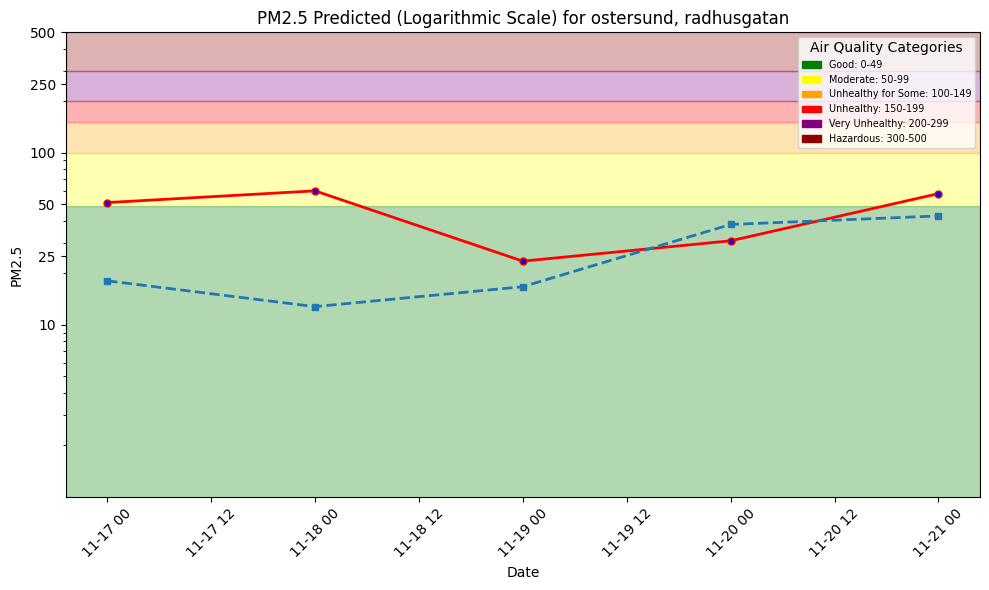

In [12]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [14]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |█| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286299/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-16 15:53:12,924 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:53:16,128 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:55:05,194 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-16 15:55:05,628 INFO: Waiting for log aggregation to finish.
2025-11-16 15:55:05,629 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [15]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_roll3,predicted_pm25_new,street,country,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,-3.65,0.0,9.826088,298.44281,ostersund,51.230469,12.0,17.982212,radhusgatan,sweden,1


In [16]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


,date,pm25,pm25_roll3,country,city,street,url
0,2024-11-21 00:00:00+00:00,7.0,4.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972
1,2025-06-02 00:00:00+00:00,14.0,11.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972
2,2022-09-15 00:00:00+00:00,5.0,8.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972
3,2025-07-29 00:00:00+00:00,16.0,20.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972
4,2024-04-29 00:00:00+00:00,6.0,27.666667,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972
...,...,...,...,...,...,...,...
1122,2023-03-12 00:00:00+00:00,51.0,42.000000,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972
1123,2023-06-22 00:00:00+00:00,35.0,52.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972
1124,2023-10-14 00:00:00+00:00,3.0,9.666667,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972
1125,2025-10-27 00:00:00+00:00,3.0,7.000000,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972


In [17]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25','predicted_pm25_new']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    hindcast_df = util.backfill_predictions_for_monitoring_combined(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, retrieved_xgboost_model_roll3)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.87s) 


Uploading Dataframe: 100.00% |█| Rows 10/10 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286299/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-16 15:55:28,162 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:55:31,351 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:57:13,919 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:57:14,074 INFO: Waiting for log aggregation to finish.
2025-11-16 15:57:22,671 INFO: Execution finished successfully.


,date,pm25,pm25_roll3,country,city,street,url,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,predicted_pm25_new,days_before_forecast_day
1117,2025-11-06 00:00:00+00:00,9.0,7.000000,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,3.718250,0.0,9.939196,253.324890,21.742134,16.300280,1
1118,2025-11-07 00:00:00+00:00,6.0,6.666667,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,2.101583,5.9,8.958504,75.796402,9.114729,4.029249,1
1119,2025-11-08 00:00:00+00:00,7.0,7.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,3.799500,0.8,12.049249,193.154556,23.224361,19.154112,1
1120,2025-11-09 00:00:00+00:00,4.0,7.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,2.826583,0.6,12.768586,63.981155,17.504705,19.314554,1
1121,2025-11-10 00:00:00+00:00,2.0,5.666667,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,-0.808833,2.9,11.126562,84.498474,3.610161,1.725500,1
1122,2025-11-11 00:00:00+00:00,4.0,4.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,1.851583,0.9,19.386593,182.301407,14.183907,12.887031,1
1123,2025-11-12 00:00:00+00:00,2.0,3.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,5.437000,2.3,24.251284,199.608063,11.262595,3.897444,1
1124,2025-11-13 00:00:00+00:00,28.0,2.666667,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,0.732833,0.0,27.869209,298.942657,16.280756,10.165612,1
1125,2025-11-14 00:00:00+00:00,6.0,11.333333,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,-1.767167,0.7,21.836456,302.347382,17.091578,6.854357,1
1126,2025-11-15 00:00:00+00:00,2.0,12.666667,sweden,ostersund,radhusgatan,https://api.waqi.info/feed/@13972,1.300000,0.1,18.032370,243.946564,9.938906,16.285543,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

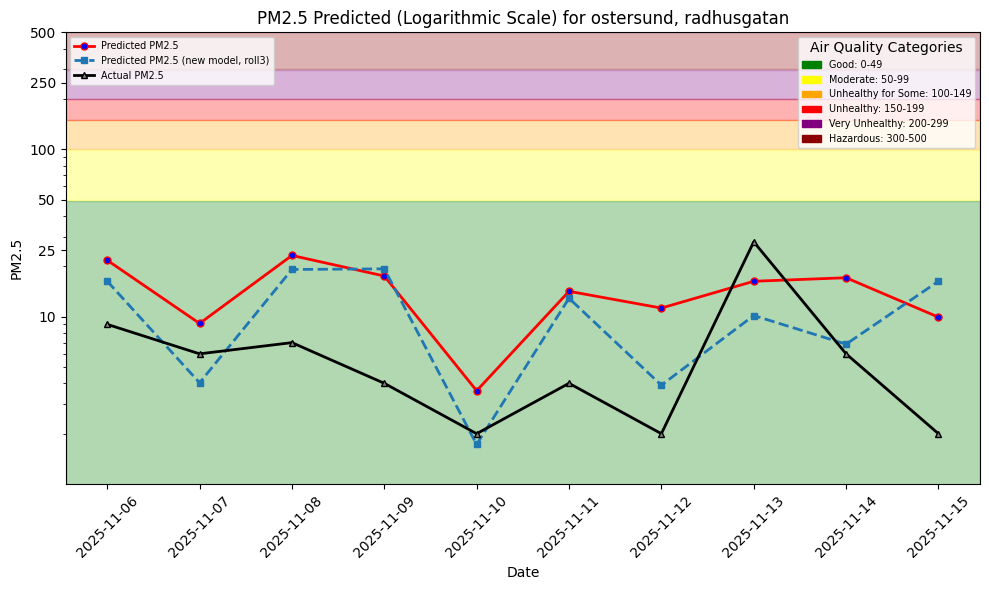

In [18]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [19]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286299/settings/fb/path/Resources/airquality


---